In [1]:
from deap import base, creator, tools, algorithms
import deap.benchmarks.tools as bt
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi
import operator
import pandas as pd

creator.create("obj", base.Fitness, weights=(-1.0))
creator.create("Ind", list, fitness=creator.obj)

In [2]:
checkpoint_file = "checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

In [3]:
cp["input_file"]

{'control_variables': {'total_pf': {'min': 0.01, 'max': 0.04},
  'r1': {'min': 0.05, 'max': 0.35},
  'r2': {'min': 0.05, 'max': 0.35},
  'r3': {'min': 0.05, 'max': 0.35},
  'r4': {'min': 0.05, 'max': 0.35},
  'r5': {'min': 0.05, 'max': 0.35}},
 'evaluators': {'openmc': {'order': 0,
   'input_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc.py'],
   'execute': [['aprun -n 2 -d 64 --env OMP_NUM_THREADS=64 openmc-0.12.2']],
   'inputs': ['total_pf', 'r1', 'r2', 'r3', 'r4', 'r5'],
   'output_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc_output.py'],
   'outputs': ['total_pf', 'keff']}},
 'constraints': {'keff': {'operator': ['>='], 'constrained_val': [1.0]}},
 'algorithm': {'objective': ['min'],
  'weight': [1.0],
  'optimized_variable': ['total_pf'],
  'pop_size': 64,
  'generations': 2,
  'parallel': 'job_control',
  'keep_files': 'all',
  'mutation_probability': 0.23,
  'mating_probability': 0.47,
  'selection_operat

In [4]:
def get_ind_list(pop_list, index):
    ind_list = [] 
    for pop in pop_list:
        ind_list.append(pop[index])
    return ind_list

In [5]:
def plot_1_obj(logbook, index, obj_name, short_name, save_fig, save_fig_title):
    gen = logbook.select("gen")
    obj_avg = get_ind_list(logbook.chapters["oup"].select("avg"), index)
    obj_std = get_ind_list(logbook.chapters["oup"].select("std"), index)
    obj_min = get_ind_list(logbook.chapters["oup"].select("min"), index)
    obj_max = get_ind_list(logbook.chapters["oup"].select("max"), index)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(15,7))
    ax.errorbar(gen, obj_avg, yerr=obj_std, label="Ave "+ short_name, capsize=5)
    ax.plot(gen, obj_min, "*-", label="Min "+ short_name)
    ax.plot(gen, obj_max, "*-", label="Max "+ short_name)
    ax.set_xlabel("Generation", fontsize=20)
    ax.set_ylabel(obj_name + " ("+short_name+") [-]", fontsize=18)
    ax.grid()
    ax.set_xticks([0, 1])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title(obj_name + " Evolution", fontsize=20)
    if save_fig:
        plt.savefig(save_fig_title,bbox_inches='tight')

In [6]:
logbook = cp["logbook"]

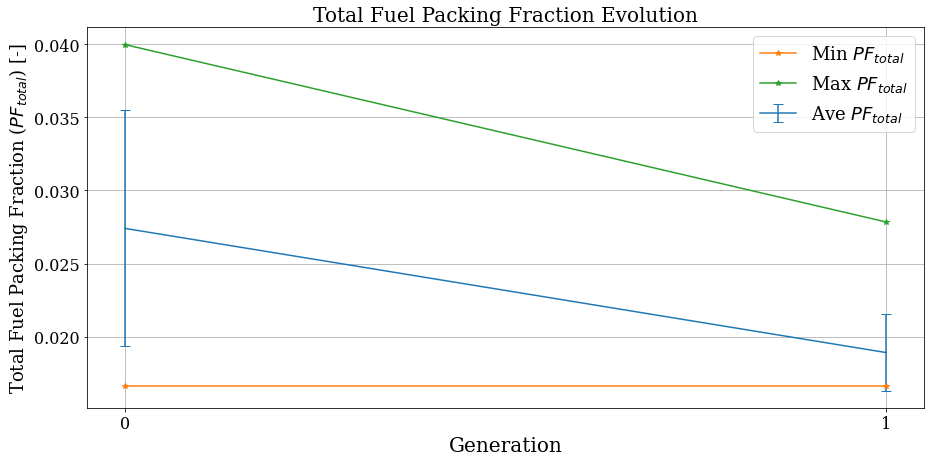

In [7]:
plot_1_obj(logbook, 0, "Total Fuel Packing Fraction", "$PF_{total}$", True, "slab-obj-1-pf-evol-coolant.png")

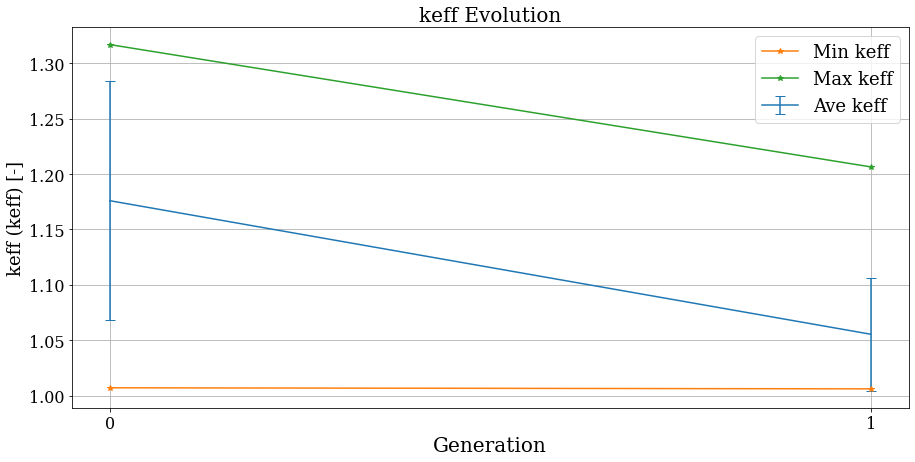

In [8]:
plot_1_obj(logbook, 1, "keff", "keff", False, "")

In [9]:
def pf_radius_plot(num):
    results = cp["all"]
    fig, ax = plt.subplots(figsize=(10,7.5))
    pop = results["populations"][-1]
    oups = results["outputs"][-1]
    obj = np.array([item[0] for item in oups])
    sorted_index_0 = np.argsort(obj)
    count, count2 = 0, 0
    for i, ind in enumerate(pop):
        oup = oups[i]
        if i in sorted_index_0[:5]:
            if count == 0:
                ax.scatter(ind[num], oup[0], color='r', marker='X', s=400, label="5 reactor models with lowest $PF_{total}$")
                count += 1
            else:
                ax.scatter(ind[num], oup[0], color='r', marker='X', s=400)
        else:
            if count2 == 0 and count > 0:
                ax.scatter(ind[num], oup[0], color='black', marker='.', s=300, label="reactor models")
                count2 += 1
            else:
                ax.scatter(ind[num], oup[0], color='black', marker='.', s=300)
    ax.set_xlim([0.05, 0.35])
    ax.set_ylim([0.01, 0.04])
    ax.set_xlabel("$r_"+str(num)+"$ [cm]", fontsize=22)
    ax.set_ylabel("Total Fuel Packing Fraction ($PF_{total}$) [-]", fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title("Final Generation: $PF_{total}$ vs Coolant Channel Shape's $r_"+str(num)+"$", fontsize=20)
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
    plt.savefig("a-1d-r"+str(num)+".png",bbox_inches='tight')

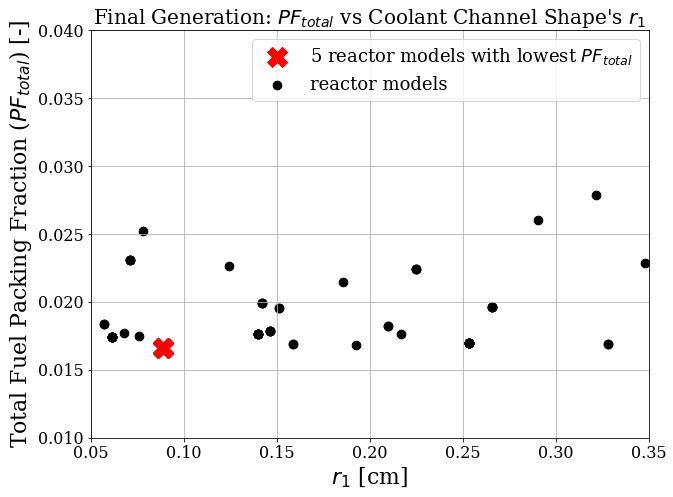

In [10]:
pf_radius_plot(1)

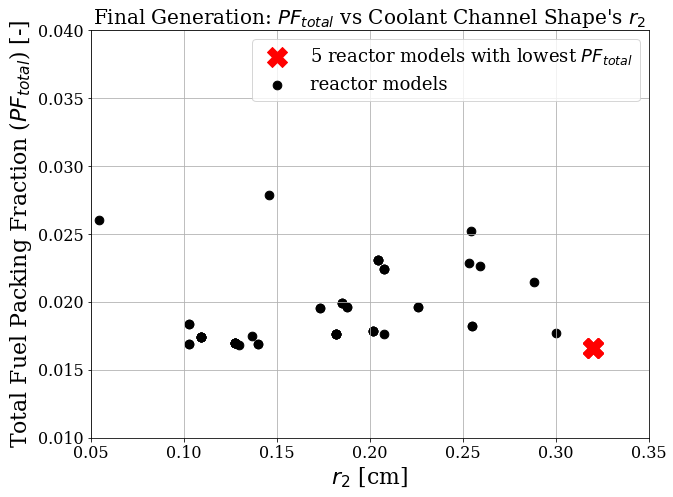

In [11]:
pf_radius_plot(2)

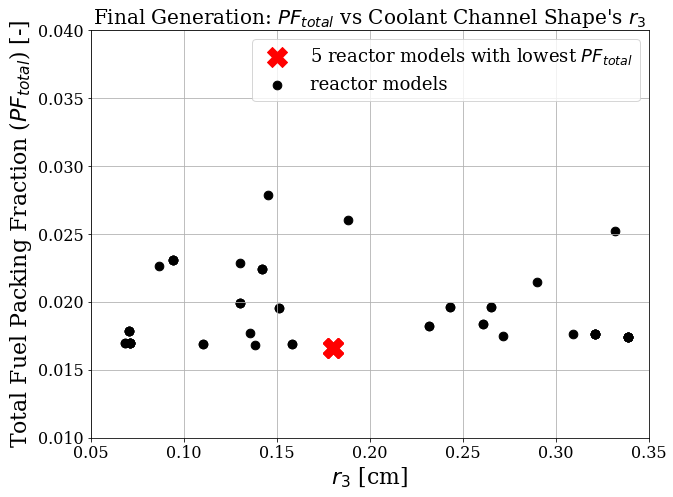

In [12]:
pf_radius_plot(3)

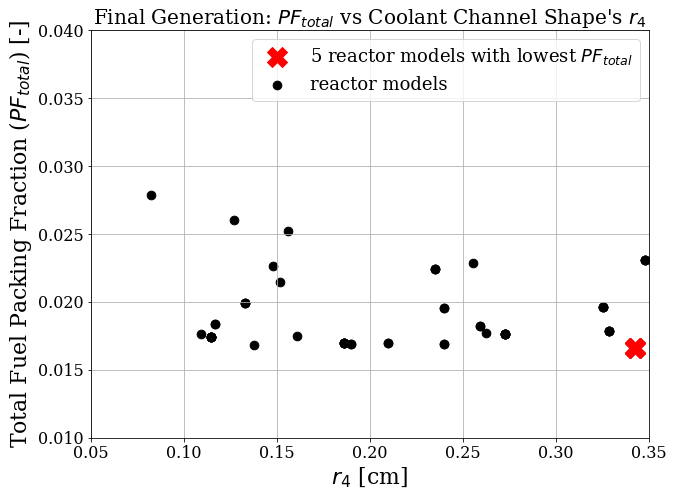

In [13]:
pf_radius_plot(4)

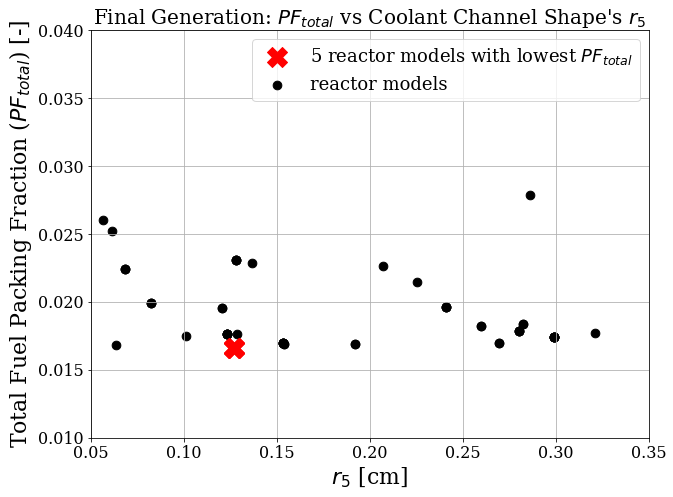

In [14]:
pf_radius_plot(5)

In [15]:
# no correlation it seems. 